# Exp 12. 한국어 데이터로 챗봇 만들기
- 번역기는 인코더와 디코더 두 가지 아키텍처로 구성되어 있다. 인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성한다. 
- 비단 번역기에만 한정되지 않는데, 질문에 대해서 대답을 하도록 구성된 데이터셋을 인코더와 디코더 구조로 학습한다면, 주어진 질문에 답변할 수 있는 챗봇을 만들 수 있다. 

## 1. 챗봇의 병렬 데이터 받아오기
- 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터 사용

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv(os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv')
dataset

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
# 샘플 개수 확인
print(len(dataset))

11823


In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글 자음과 모음으로 정규 표현식 작성
    sentence = re.sub(r"[ㄱ-ㅎㅏ-ㅣ?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():

    inputs, outputs = [], []

    for i in range(len(dataset) - 1):
        inputs.append(preprocess_sentence(dataset['Q'][i]))
        outputs.append(preprocess_sentence(dataset['A'][i]))
            
    return inputs, outputs

In [6]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


In [7]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요


## 2. 병렬 데이터 전처리하기
1. SubwordTextEncoder를 토크나이저로 사용한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩한다. 
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 `START_TOKEN` 및 `END_TOKEN`을 추가한다. 
3. 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다. 
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩한다.  

### (1) 단어장 만들기
- 우선 각 단어에 고유한 정수 인덱스를 부여하기 위해 단어장을 만들어보자. 이 때 질문과 답변 데이터셋을 모두 사용해 만든다. 

In [8]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [9]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [10]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8151]
END_TOKEN의 번호 : [8152]


In [11]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8153


### (2) 각 단어를 고유한 정수로 인코딩 & 패딩
- 앞서 tokenizer를 정의하고 단어장을 만들었다면, `tokenizer.encode()`로 각 단어를 정수로 변환할 수 있고, `decode()`로 반대도 가능하다. 

In [12]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5748, 605, 2480, 4150]
정수 인코딩 후의 21번째 답변 샘플: [2346, 7493, 6, 6257, 95]


In [13]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 10
print(MAX_LENGTH)

10


In [14]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8153
필터링 후의 질문 샘플 개수: 9901
필터링 후의 답변 샘플 개수: 9901


### (3) 교사 강요 (Teacher Forcing) 사용하기
- tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API다.  
- 이를 적극 사용하기 위해서 질문과 답변의 쌍을 `tf.data.Dataset`의 입력으로 넣어주는 작업을 한다.  
- 이 때, 디코더의 입력과 실제값(레이블)을 정의해주기 위해서는 교사 강요라는 언어 모델의 훈련 기법을 이해해야만 한다. 
- 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델이라고 한다. 트랜스포머의 디코더 또한 자기회귀 모델이다. 

In [16]:
# 질문과 답변의 상을 tf.data.Dataset API의 입력으로 사용해 파이프라인 구성
# 교사 강요를 위해서 answer[:, :-1]를 디코드의 입력값, answer[:, 1:]를 디코더의 레이블로 사용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 output에서는 START_TOKEN을 제거한다
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs':questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 3. 모델 정의 및 학습하기

In [17]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        # tf.pow : 거듭제곱 값을 계산, tf.cast : 텐서를 새로운 형태로 캐스트
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cos 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cos이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [18]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # assert는 뒤의 조건의 True가 아니면 AssertError를 발생한다. (방어적 프로그래밍)
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 생성
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 concatenate
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # 최종 결과에도 Dense 한 번 더 적용
        outputs = self.dense(concat_attention)
        
        return outputs

In [20]:
# 패딩 마스킹 구현 함수
# 이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크해 벡터를 리턴한다. 
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [21]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 인코더
- 하나의 인코더 층은 크게 총 2개의 서브 층으로 나뉜다. 바로 셀프 어텐션과 피드 포워드 신경망이다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어진다.

In [22]:
# 인코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
def encoder(vocab_size,
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name="encoder"):
    inputs = tf.keras.Input(shape=(None, ), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더 층
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i), )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더
- 디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡하다. 
- 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다르다. 
- 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망이다. 
- 인코더-디코더 어텐션은 셀프 어텐션과는 달리, 쿼리가 디코더의 벡터인 반면에 키와 밸류가 인코더의 벡터라는 특징이 있다.
- 인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다.

In [24]:
# 디코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    
    # 마스크드 멀티 헤드 어텐션의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [25]:
def decoder(vocab_size, 
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name="decoder"):
    inputs = tf.keras.Input(shape=(None, ), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i), )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

- 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용해 트랜스포머 함수를 정의한다. 

In [26]:
def transformer(vocab_size, 
               num_layers,
               units,
               d_model,
               num_heads,
               dropout,
               name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크하기 위해 사용
    # 내부적으로 패딩 마스크도 포함되어져 있다. 
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### (1) 모델 생성
- `num_layers`, `d_Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼파라미터 값이다. 
- 논문에서 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 논문에서보다 작은 값을 사용한다. 

In [27]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6  # 인코더와 디코더 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13642240    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### (2) 손실 함수
- 레이블인 시퀀스에 패딩이 되어 있기 때문에, loss를 계산할 때 패딩 마스크를 적용해야 한다. 

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

### (3) 커스텀된 학습률 (Learning rate)
- 딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터다. 최근에는 모델학습 초기에 learning rate를 급격하게 높였다가 이후 train step이 진행됨에 따라 서서히 낮춰가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링이라고 한다. 
- 논문에 나온 공식을 참고해 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용한다. 

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다. 

Text(0.5, 0, 'Train Step')

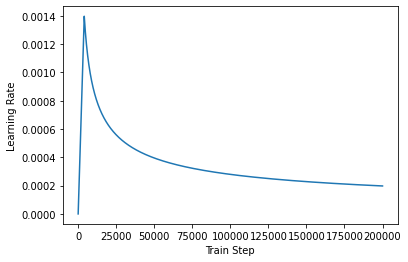

In [30]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### (4) 모델 컴파일
- 손실 함수와 커스텀된 학습률을 사용해 모델을 컴파일한다. 

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [32]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
155/155 [==============================] - 30s 80ms/step - loss: 4.6468 - accuracy: 0.0966
Epoch 2/100
155/155 [==============================] - 12s 80ms/step - loss: 4.0737 - accuracy: 0.1111
Epoch 3/100
155/155 [==============================] - 12s 80ms/step - loss: 3.7428 - accuracy: 0.1128
Epoch 4/100
155/155 [==============================] - 12s 80ms/step - loss: 3.5732 - accuracy: 0.1179
Epoch 5/100
155/155 [==============================] - 12s 80ms/step - loss: 3.4664 - accuracy: 0.1238
Epoch 6/100
155/155 [==============================] - 12s 80ms/step - loss: 3.3717 - accuracy: 0.1278
Epoch 7/100
155/155 [==============================] - 12s 80ms/step - loss: 3.2399 - accuracy: 0.1377
Epoch 8/100
155/155 [==============================] - 12s 80ms/step - loss: 3.0660 - accuracy: 0.1496
Epoch 9/100
155/155 [==============================] - 12s 80ms/step - loss: 2.8552 - accuracy: 0.1641
Epoch 10/100
155/155 [==============================] - 12s 80ms/step - l

## 4. 챗봇 테스트하기
예측(inference) 단계는 기본적으로 다음 과정을 거친다. 
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다. 
2. 입력 문장을 토크나이징하고, `START_TOKEN`, `END_TOKEN`을 추가한다. 
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다. 
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가해 새로운 입력으로 사용한다. 
6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  

위의 과정을 모두 담은 `decoder_inference()` 함수를 만든다

In [33]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복한다. 
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        
        # 예측한 단어들은 지속적으로 output_sequence에 추가된다. 
        # 이 output_sequence는 다시 디코더의 입력이 된다. 
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

- 임의의 입력 문장에 대해서 `decoder_inference()` 함수를 호출해 챗봇의 대답을 얻는 `sentence_generation()` 함수를 만든다.

In [34]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받는다. 
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

In [35]:
sentence_generation('쉽지 않아')

입력 : 쉽지 않아
출력 : 수고 많았어요


'수고 많았어요'

In [36]:
sentence_generation('이름이 뭐야')

입력 : 이름이 뭐야
출력 : 위로봇이요


'위로봇이요'

In [37]:
sentence_generation('아이펠')

입력 : 아이펠
출력 : 또 한잔 길 바랍니다


'또 한잔 길 바랍니다'

In [38]:
sentence_generation('으악')

입력 : 으악
출력 : 놀랐나봐요


'놀랐나봐요'

## 5. 회고
- 한국어 데이터를 형태소 분석기가 아니라 노드에서 사용한 `SubwordTextEncoder`를 그대로 사용했음에도 질문에 대해 꽤 괜찮은 답변을 주는 것이 신기했다. 
- 학습 시 accuarcy는 상당히 낮게 나오는데 비해서 챗봇의 결과는 꽤나 준수한 것 같다. 교사 강요라는 개념도 처음 본 것 같은데 신기했다. 
- 역시나 자연어 처리는 정규표현식을 이용한 전처리가 까다롭다는 것을 느꼈고, 트랜스포머의 구조에 대해 좀 자세히 알게 된 노드였던 것 같다. 인코더와 디코더, 포지셔널 인코딩, 어텐션, 마스킹 기법 등 차근차근 짚고 넘어갈 수 있어서 좋았다. 하지만 머리는... 아프다. 
- 추가 : 괜히 조금만 더 건드려보고 싶어서... `NUM_LAYER`를 4로, `EPOCHS`를 100으로 해서 돌려보니 accuracy가 0.1487에 수렴했고, 입력된 문장에 대한 예측 결과에는 큰 변화가 없었다. (아이펠이라는 말에 헛소리를 하는 것도!) 그래서 논문대로 한 번 더 돌려보기로 했다.  
- 추가2 : 노드에서 언급한 논문과 같이 `NUM_LAYER`를 6으로, `D_MODEL`을 512로 해서 100 에폭을 돌렸는데 loss는 꾸준히 줄었고, accuracy는 앞 결과와 비슷하게 0.1482에 수렴했다. 아마 데이터셋이 단편적이라서 이 이상의 결과가 안 나오는건지... 의문이지만 단편적인 질문에 대한 답변은 꽤 그럴싸하다는 것을 알 수 있었다. 
- 추가3 : 이미 제출해놓고 계속 뭘 추가하고 있긴 한데... 사실 accuracy가 0.14 수준에서 계속 수렴하는 것이 뭔가 마음에 걸리던 중에 다현님의 프로젝트를 봤는데 문장 길이 제한을 기존 노드와 동일한 40으로만 돌린 나와는 다르게 데이터셋의 평균 문장 길이를 체크하고 문장 길이 제한을 10으로 바꾸셔서 accuracy가 0.6이 넘게 나오셨다! 데이터셋을 뜯어보고 그에 맞게 전처리하는 건 여러 노드를 통해 배운 사실인데도 간과하고 있었던 것이다. 다현님의 정보를 바탕으로 문장 길이 제한을 10으로 설정하니 accuracy가 0.577에 수렴했다! 주어진 데이터셋에 대해 파악하는 것을 잊지 말자! 